# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os
from os import listdir
import cv2
from scipy.spatial import distance
import xmltodict

import torch
from torchvision import transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import tensorflow as tf

import sys
import torch.optim as optim
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

import tensorflow_addons as tfa
import tensorflow.keras.layers as tfl
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Extraction of Images and Annotations

In [2]:
img_names=[] 
xml_names=[] 
for dirname, _ , filenames in os.walk('Data'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [3]:
path_annotations="Data/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['without_mask', 'with_mask', 'mask_weared_incorrect']) 
 dict_values([717, 3232, 123])


# Data Viz & Analysis of the Target Label

C:\Users\Mr. Pedram\AppData\Local\Temp\ipykernel_2928\3044177961.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


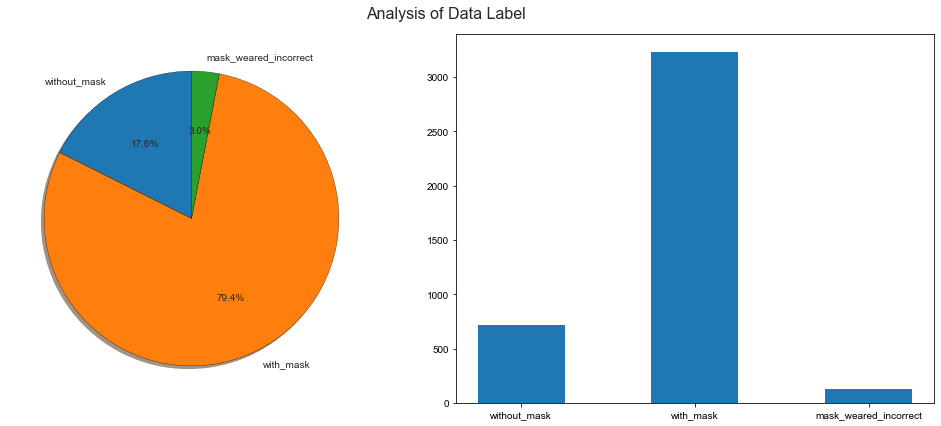

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
plt.style.use('seaborn')
ax1.pie(list(values) , labels=list(Items), shadow=True , startangle=90 ,autopct='%1.1f%%' , wedgeprops={'edgecolor': 'black'})
ax2.bar(list(Items) , height = list(values) , width = .5)
fig.suptitle('Analysis of Data Label' , fontsize=16)
plt.tight_layout()
plt.show()

# Images Identification with Target Class

As there are 3 classes in target, we can use 3 colors for cascading the face.
* Red --> without_mask
* Green --> with_mask
* Yellow -- > mask_weared_incorrect

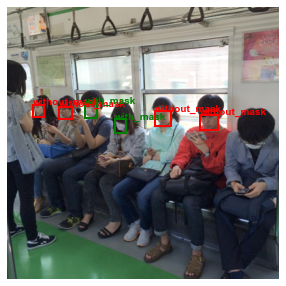

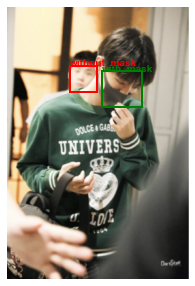

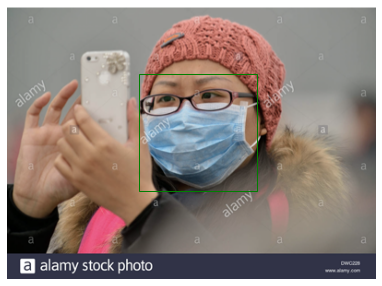

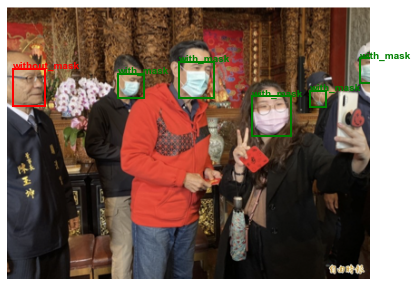

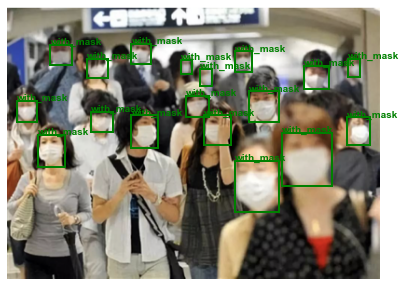

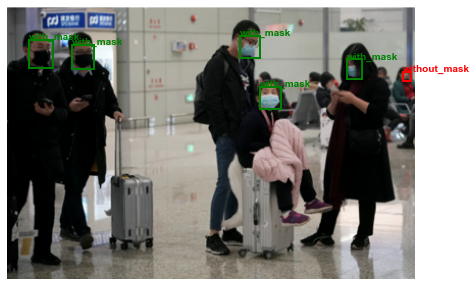

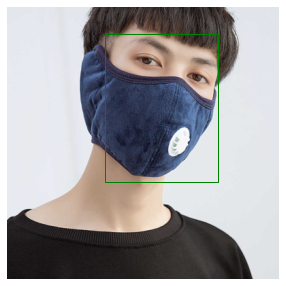

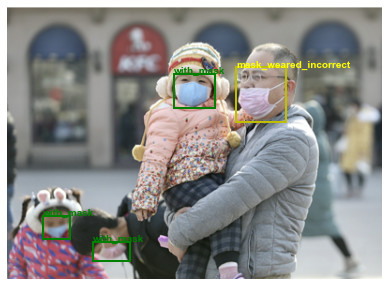

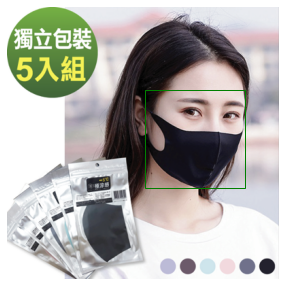

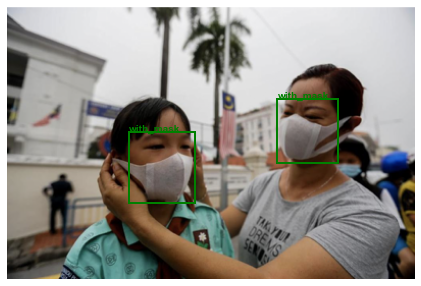

In [5]:
path_image="Data/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())

    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1,figsize = (10,5))
    ax.axis("off")
    temp=doc["annotation"]["object"]
    if isinstance(temp,list):
        for i in range(len(temp)):
            # with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            
            
            # without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            
            
            # mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

rand_images = img_names.copy()
for  i in np.random.randint(0 , np.sum(len(img_names)) , size=10):
    face_cas(rand_images[i])

# Image Preprocessing

In [6]:
options = {"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 

In [7]:
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())

        if isinstance(doc["annotation"]["object"] , list):
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]                
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))


        else:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((256,256)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names)

Converting torch.tensor to tf.tensor

In [8]:
mydataset = tuple([list((tf.convert_to_tensor(y.numpy()) for y in x)) for x in mydataset])

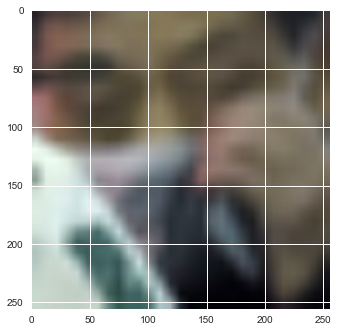

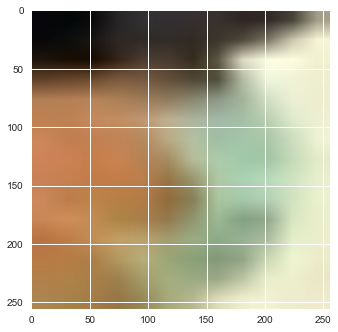

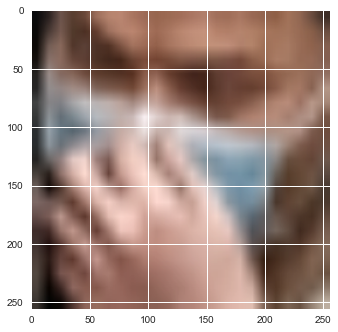

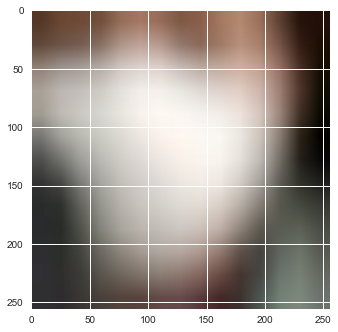

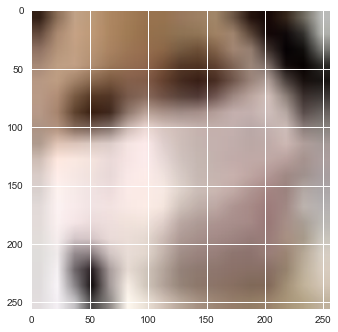

In [9]:
for i in np.random.randint(0,len(mydataset),5):
    img = tf.keras.preprocessing.image.array_to_img(mydataset[i][0] , data_format="channels_first")
    plt.imshow(img)
    plt.show()

# Saving the cropped images

In [10]:
for i in range(len(mydataset)):
    label = int(mydataset[i][1])
    img = mydataset[i][0]
    tf.keras.utils.save_img(f"edited pics/{i}. {label}.png" , img, data_format="channels_first" , scale=True)

# Splitting Dataset into Train/Dev/Test Sets

In [11]:
images_path = []
images_label = []
# get the path/directory
folder_dir = "edited pics"
for images in os.listdir(folder_dir):

	# check if the image ends with png
	if (images.endswith(".png")):
		# print(images[-5:-4])
		images_path.append(images)
		images_label.append(images[-5:-4])

df = pd.DataFrame({'image_path':images_path , 'image_label':images_label})
df['image_label'] = df['image_label'].astype(int)
df.head()

,image_path,image_label
0,0. 1.png,1
1,1. 0.png,0
2,10. 0.png,0
3,100. 1.png,1
4,1000. 0.png,0


Removing wrongly worn masks

In [12]:
df = df[df['image_label']!=2]

In [13]:
X_train, X_test, y_train, y_test = train_test_split( df['image_path'], df['image_label'], test_size=0.2, random_state=1)
X_dev, X_test , y_dev, y_test = train_test_split( X_test, y_test, test_size=0.5, random_state=1)

In [14]:
def reading_images( X, y, path, image_size = 256):
    X_list = []
    y_list = []
    for i in X.index:

        img_array = cv2.imread(path+"/"+str(X[i]))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        new_image_array = cv2.resize(img_array.astype(np.uint8), (image_size, image_size))
        X_list.append(new_image_array)
        y_list.append(y[i])

    return X_list,y_list

In [15]:
# Reading all the image into a list and changing the size of the image to (256,256)
path = 'edited pics'

X_train_arr , y_train_arr = reading_images(X_train , y_train, path)
X_dev_arr , y_dev_arr = reading_images(X_dev , y_dev, path)
X_test_arr , y_test_arr = reading_images(X_test , y_test, path)

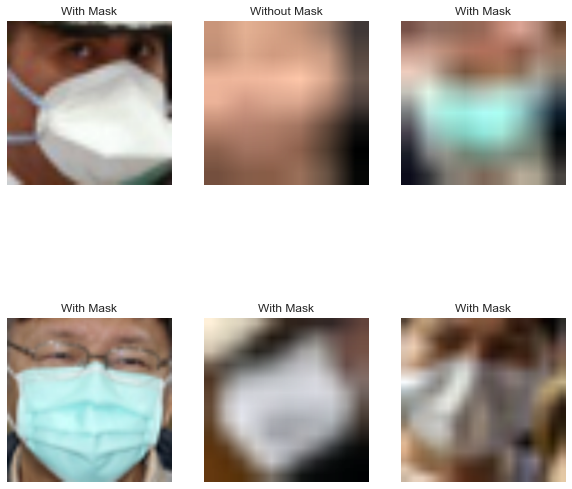

In [16]:
## Looking at the training samples

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for row in range(2):
    for col in range(3):
        idx = np.random.choice(np.arange(len(y_train_arr)))    
        ax[row, col].axis("off")
        ax[row,col].imshow(X_train_arr[idx])
    
        if y_train_arr[idx] == 0:
            ax[row, col].set_title("With Mask")
        else:
            ax[row, col].set_title("Without Mask")
            
plt.show()

### Preparing data to be loaded into the Model

In [17]:
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X_train_arr,y_train_arr = np.array(X_train_arr) , np.array(y_train_arr)
X_dev_arr,y_dev_arr = np.array(X_dev_arr) , np.array(y_dev_arr)
X_test_arr,y_test_arr = np.array(X_test_arr) , np.array(y_test_arr)

In [18]:
### Normalizing the data
X_train_arr, X_dev_arr, X_test_arr = X_train_arr/255, X_dev_arr/255, X_test_arr/255
y_train_arr, y_dev_arr, y_test_arr = y_train_arr.reshape(-1,1), y_dev_arr.reshape(-1,1), y_test_arr.reshape(-1,1)

# Implementing different Models

## First Model

Model Building

In [19]:
model = Sequential([
    Conv2D(6 , kernel_size=5 , activation = "relu" , padding='same'),
    MaxPool2D(2 , strides=2 ,padding='same'),
    Conv2D(16 , kernel_size=5 , activation='relu' , padding='same'),
    MaxPool2D(2, strides=2, padding='same'),
    Conv2D(32 , kernel_size=5 , activation = "relu" , padding='same'),
    MaxPool2D(2, strides=2, padding='same'),
    Conv2D(64 , kernel_size=5 , activation = "relu" , padding='same'),
    MaxPool2D(3, strides=2, padding='same'),
    Flatten(),
    Dense(512 , activation='relu'),
    Dense(256 , activation='relu'),
    Dense(128 , activation='relu'),
    Dense(1, activation='sigmoid')
])

In [20]:
model.compile(optimizer='adam',
              loss=
              'binary_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=1), 'accuracy'])

In [20]:
save_dir = "./results/"
model_name = '4CNN-3FC_Simple.h5'
model_path = os.path.join(save_dir, model_name)

history_simple_CNN = model.fit(X_train_arr, y_train_arr,
          batch_size=32,
          epochs=10,
          validation_data=(X_dev_arr, y_dev_arr),
          callbacks=[
            ModelCheckpoint(model_path, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=2, min_delta=0.0001, verbose=2)
          ])

Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
99/99 [==============================] - 98s 967ms/step - loss: 0.1774 - f1_score: 0.3107 - accuracy: 0.9319 - val_loss: 0.1805 - val_f1_score: 0.2937 - val_accuracy: 0.9316
Epoch 2/10
99/99 [==============================] - 106s 1s/step - loss: 0.1277 - f1_score: 0.3198 - accuracy: 0.9588 - val_loss: 0.1273 - val_f1_score: 0.2937 - val_accuracy: 0.9468
Epoch 3/10
99/99 [==============================] - 103s 1s/step - loss: 0.1194 - f1_score: 0.3112 - accuracy: 0.9579 - val_loss: 0.1082 - val_f1_score: 0.2937 - val_accuracy: 0.9544
Epoch 4/10
99/99 [==============================] - 110s 1s/step - loss: 0.1075 - f1_score: 0.3107 - accuracy: 0.9658 - val_loss: 0.1035 - val_f1_score: 0.2937 - val_accuracy: 0.9595
Epoch 5/10
99/99 [==============================] - 99s 1s/step -

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

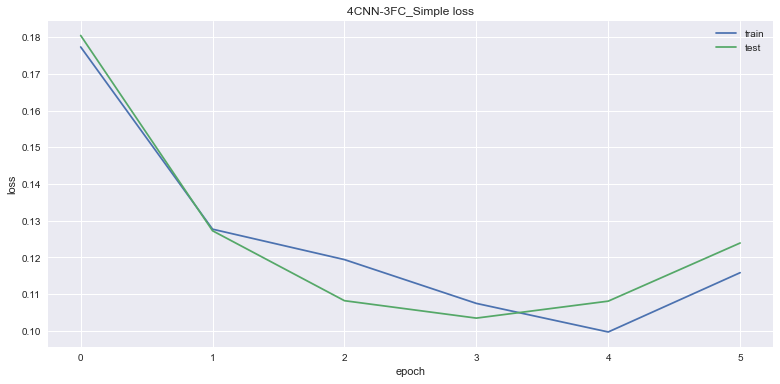

In [25]:
# plotting the metrics
fig = plt.figure(figsize=(13,6))
ax = plt.subplot(111)
ax.plot(history_simple_CNN.history['loss'])
ax.plot(history_simple_CNN.history['val_loss'])
ax.set_title('4CNN-3FC_Simple loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)
plt.show()

Loading Model

In [21]:
model = tf.keras.models.load_model('results/4CNN-3FC_Simple.h5')

Performance on Training Set

In [22]:
prediction = (model.predict(X_train_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

99/99 [==============================] - 22s 207ms/step


In [23]:
print(classification_report(prediction, y_train_arr))
print(confusion_matrix(prediction, y_train_arr))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2535
           1       0.96      0.89      0.93       624

    accuracy                           0.97      3159
   macro avg       0.97      0.94      0.95      3159
weighted avg       0.97      0.97      0.97      3159

[[2512   23]
 [  66  558]]


Performance on Dev Set

In [24]:
prediction = (model.predict(X_dev_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

13/13 [==============================] - 3s 202ms/step


In [25]:
print(classification_report(prediction, y_dev_arr))
print(confusion_matrix(prediction, y_dev_arr))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       317
           1       0.96      0.83      0.89        78

    accuracy                           0.96       395
   macro avg       0.96      0.91      0.93       395
weighted avg       0.96      0.96      0.96       395

[[314   3]
 [ 13  65]]


Performance on Test Set

In [26]:
prediction = (model.predict(X_test_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

13/13 [==============================] - 3s 205ms/step


In [27]:
print(classification_report(prediction, y_test_arr))
print(confusion_matrix(prediction, y_test_arr))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       322
           1       0.97      0.90      0.94        73

    accuracy                           0.98       395
   macro avg       0.97      0.95      0.96       395
weighted avg       0.98      0.98      0.98       395

[[320   2]
 [  7  66]]


## Second Model

Model Building

In [23]:
model_2 = Sequential([
    Conv2D(6 , kernel_size=5 , activation = "relu" , padding='same'),
    MaxPool2D(3 , strides=2 ,padding='same'),
    Conv2D(10 , kernel_size=5 , activation='relu' , padding='valid'),
    MaxPool2D(3, strides=1, padding='same'),
    Flatten(),
    Dense(128 , activation='relu'),
    Dense(64 , activation='relu'),
    Dense(1, activation='sigmoid')
])

In [27]:
model_2.compile(optimizer='adam',
              loss=
              'binary_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=1), 'accuracy'])

In [28]:
save_dir = "./results/"
model_name = '2CNN-2FC_Simple.h5'
model_path = os.path.join(save_dir, model_name)

history_simple_CNN2 = model_2.fit(X_train_arr, y_train_arr,
          batch_size=32,
          epochs=10,
          validation_data=(X_dev_arr, y_dev_arr),
          callbacks=[
            ModelCheckpoint(model_path, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=2, min_delta=0.0001, verbose=2)
          ])

Epoch 1/10
99/99 [==============================] - 90s 883ms/step - loss: 0.3108 - f1_score: 0.3122 - accuracy: 0.8949 - val_loss: 0.1172 - val_f1_score: 0.2937 - val_accuracy: 0.9519
Epoch 2/10
99/99 [==============================] - 91s 915ms/step - loss: 0.1008 - f1_score: 0.3141 - accuracy: 0.9677 - val_loss: 0.1018 - val_f1_score: 0.2937 - val_accuracy: 0.9595
Epoch 3/10
99/99 [==============================] - 90s 906ms/step - loss: 0.1030 - f1_score: 0.3111 - accuracy: 0.9642 - val_loss: 0.1117 - val_f1_score: 0.2937 - val_accuracy: 0.9671
Epoch 4/10
99/99 [==============================] - 94s 949ms/step - loss: 0.0725 - f1_score: 0.3120 - accuracy: 0.9750 - val_loss: 0.1008 - val_f1_score: 0.2944 - val_accuracy: 0.9646
Epoch 5/10
99/99 [==============================] - 88s 888ms/step - loss: 0.0790 - f1_score: 0.3221 - accuracy: 0.9734 - val_loss: 0.1032 - val_f1_score: 0.2944 - val_accuracy: 0.9620
Epoch 6/10
99/99 [==============================] - 94s 953ms/step - loss: 

In [29]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 6)       456       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 10)      1510      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 124, 124, 10)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 153760)            0         
                                                                 
 dense_4 (Dense)             (None, 128)              

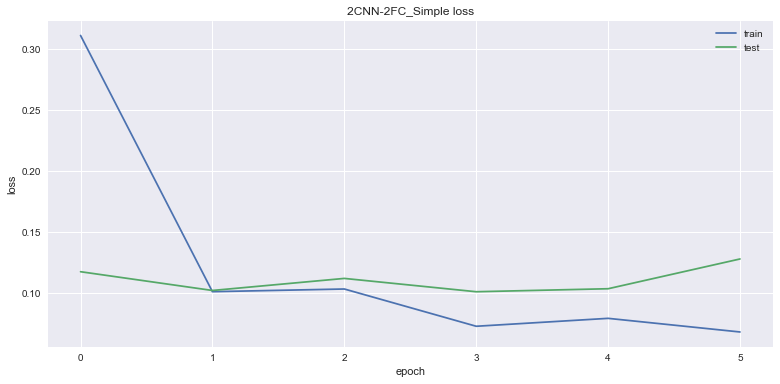

In [34]:
# plotting the metrics
fig = plt.figure(figsize=(13,6))
ax = plt.subplot(111)
ax.plot(history_simple_CNN2.history['loss'])
ax.plot(history_simple_CNN2.history['val_loss'])
ax.set_title('2CNN-2FC_Simple loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)
plt.show()

Loading Model

In [37]:
model_2 = tf.keras.models.load_model('results/2CNN-2FC_Simple.h5')

Performance on Train Set

In [38]:
prediction = (model_2.predict(X_train_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

99/99 [==============================] - 22s 200ms/step


In [39]:
print(classification_report(prediction, y_train_arr))
print(confusion_matrix(prediction, y_train_arr))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2598
           1       0.92      0.95      0.94       561

    accuracy                           0.98      3159
   macro avg       0.95      0.97      0.96      3159
weighted avg       0.98      0.98      0.98      3159

[[2551   47]
 [  27  534]]


Performance on Dev Set

In [40]:
prediction = (model_2.predict(X_dev_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

13/13 [==============================] - 3s 184ms/step


In [41]:
print(classification_report(prediction, y_dev_arr))
print(confusion_matrix(prediction, y_dev_arr))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       327
           1       0.90      0.90      0.90        68

    accuracy                           0.96       395
   macro avg       0.94      0.94      0.94       395
weighted avg       0.96      0.96      0.96       395

[[320   7]
 [  7  61]]


Performance on Test Set

In [42]:
prediction = (model_2.predict(X_test_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

13/13 [==============================] - 3s 228ms/step


In [43]:
print(classification_report(prediction, y_test_arr))
print(confusion_matrix(prediction, y_test_arr))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       328
           1       0.90      0.91      0.90        67

    accuracy                           0.97       395
   macro avg       0.94      0.94      0.94       395
weighted avg       0.97      0.97      0.97       395

[[321   7]
 [  6  61]]


## Third Model

Model Building

In [12]:
model_3 = Sequential([
    Conv2D(32 , kernel_size=3 , activation = "relu" , padding='same'),
    MaxPool2D(3, strides=1, padding='same'),
    Conv2D(64 , kernel_size=3 , activation='relu' , padding='valid'),
    MaxPool2D(3, strides=1, padding='valid'),
    Flatten(),
    Dense(128 , activation='relu'),
    Dense(1, activation='sigmoid')
])

In [13]:
model_3.compile(optimizer='adam',
              loss=
              'binary_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=1), 'accuracy'])

In [15]:
save_dir = "./results/"
model_name = '2CNN-1FC_Simple.h5'
model_path = os.path.join(save_dir, model_name)

history_simple_CNN3 = model_3.fit(X_train_arr, y_train_arr,
          batch_size=32,
          epochs=5,
          validation_data=(X_dev_arr, y_dev_arr),
          callbacks=[
            ModelCheckpoint(model_path, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=1, min_delta=0.0001)
          ])

Epoch 1/5
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
99/99 [==============================] - 2346s 24s/step - loss: 4.5316 - f1_score: 0.3920 - accuracy: 0.9240 - val_loss: 0.1626 - val_f1_score: 0.3049 - val_accuracy: 0.9392
Epoch 2/5
99/99 [==============================] - 2276s 23s/step - loss: 0.1124 - f1_score: 0.3404 - accuracy: 0.9661 - val_loss: 0.1218 - val_f1_score: 0.3301 - val_accuracy: 0.9570
Epoch 3/5
99/99 [==============================] - 2269s 23s/step - loss: 0.0961 - f1_score: 0.3474 - accuracy: 0.9715 - val_loss: 0.1292 - val_f1_score: 0.3350 - val_accuracy: 0.9570


In [16]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 252, 252, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4064256)           0         
                                                                 
 dense (Dense)               (None, 128)               5

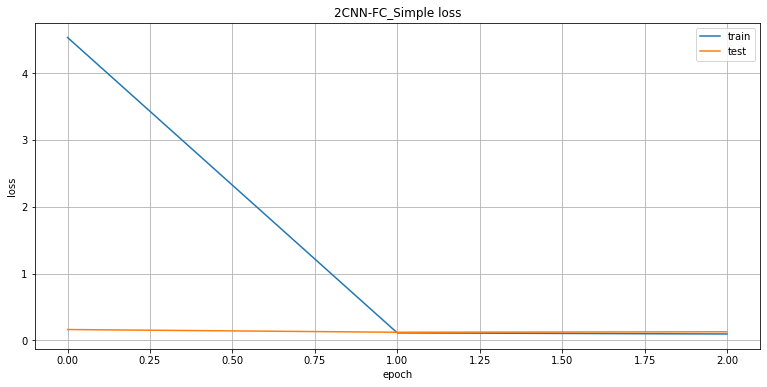

In [18]:
# plotting the metrics
fig = plt.figure(figsize=(13,6))
ax = plt.subplot(111)
ax.plot(history_simple_CNN3.history['loss'])
ax.plot(history_simple_CNN3.history['val_loss'])
ax.set_title('2CNN-FC_Simple loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)
plt.show()

Loading Model

In [10]:
model_3 = tf.keras.models.load_model('results/2CNN-1FC_Simple.h5')

Performance on Train Set

In [11]:
prediction = (model_3.predict(X_train_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

99/99 [==============================] - 167s 2s/step


In [12]:
print(classification_report(prediction, y_train_arr))
print(confusion_matrix(prediction, y_train_arr))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2553
           1       0.94      0.90      0.92       606

    accuracy                           0.97      3159
   macro avg       0.96      0.94      0.95      3159
weighted avg       0.97      0.97      0.97      3159

[[2518   35]
 [  60  546]]


Performance on Dev Set

In [13]:
prediction = (model_3.predict(X_dev_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

13/13 [==============================] - 15s 1s/step


In [14]:
print(classification_report(prediction, y_dev_arr))
print(confusion_matrix(prediction, y_dev_arr))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       320
           1       0.93      0.84      0.88        75

    accuracy                           0.96       395
   macro avg       0.94      0.91      0.93       395
weighted avg       0.96      0.96      0.96       395

[[315   5]
 [ 12  63]]


Performance on Test Set

In [15]:
prediction = (model_3.predict(X_test_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

13/13 [==============================] - 17s 1s/step


In [17]:
print(classification_report(prediction, y_test_arr))
print(confusion_matrix(prediction, y_test_arr))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       324
           1       0.91      0.87      0.89        71

    accuracy                           0.96       395
   macro avg       0.94      0.93      0.93       395
weighted avg       0.96      0.96      0.96       395

[[318   6]
 [  9  62]]


# Misclassified Images
In this section we use the best model (which was the second model) and see a smaple of the images misclassified.

In [10]:
model = tf.keras.models.load_model('results/2CNN-2FC_Simple.h5')
prediction = (model.predict(X_test_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

13/13 [==============================] - 3s 182ms/step


In [11]:
df_test = df.loc[X_test.index]
df_test['prediction'] = prediction

Now, we filter the rows that the prediction is not analogous to the true label.

In [12]:
mask = df_test['prediction'] != df_test['image_label']
df_diff = df_test.loc[mask]
df_diff

,image_path,image_label,prediction
2924,363. 0.png,0,1
3851,80. 1.png,1,0
1069,1960. 1.png,1,0
879,179. 1.png,1,0
798,1716. 1.png,1,0
1068,196. 0.png,0,1
2732,3457. 0.png,0,1
789,1708. 1.png,1,0
3740,70. 1.png,1,0
1127,2011. 0.png,0,1


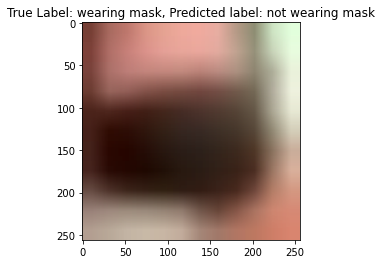

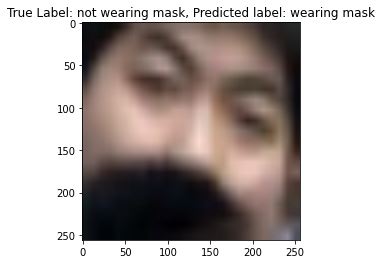

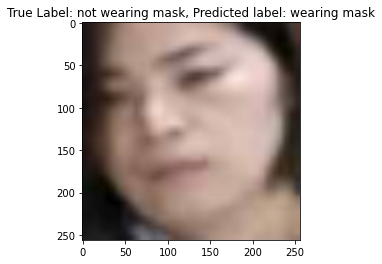

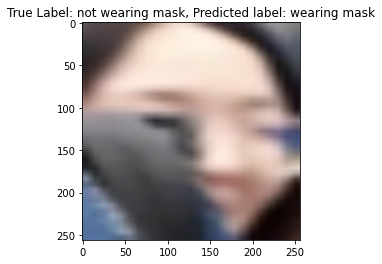

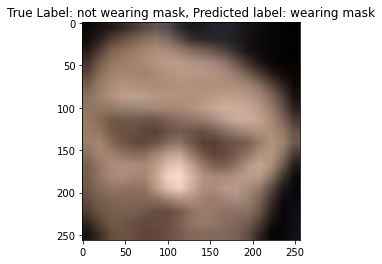

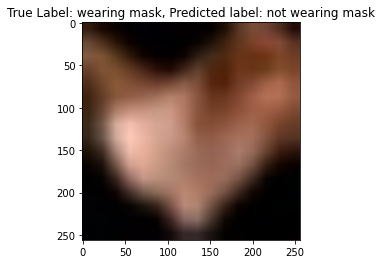

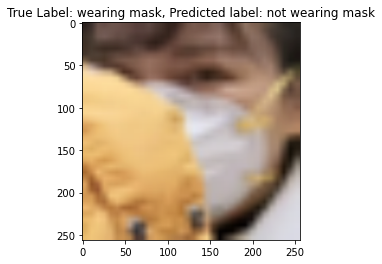

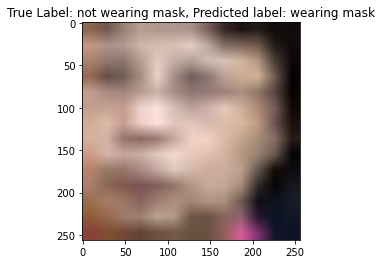

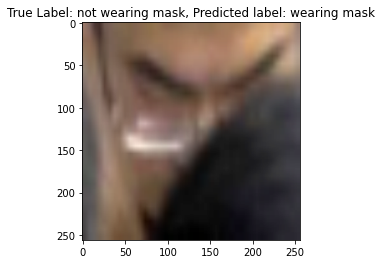

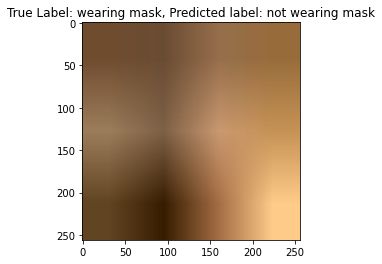

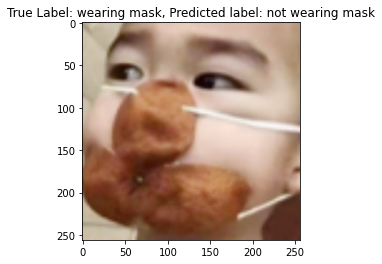

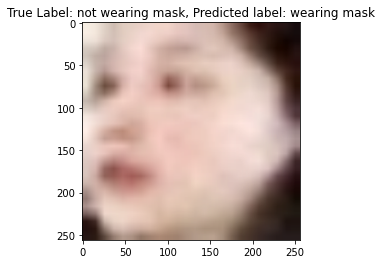

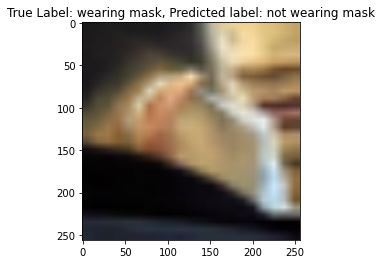

In [28]:
path= 'edited pics/'
dic = {0: 'wearing mask' , 1:'not wearing mask'}


for idx in df_diff.index:
    plt.title(f"True Label: {dic[df_diff.loc[idx , 'image_label']]}, Predicted label: {dic[df_diff.loc[idx , 'prediction']]}")
    image = mpimg.imread(path + df_diff.loc[idx , 'image_path'])
    plt.imshow(image)
    plt.show()


It's outright that the mislabeled images are those which are either low in resolution or their faces aren't clear enough. So our classifier is doing very well.